#  SIRV on network with hesitancy

#### Introduction and main goals
In this project we want to asses what are the effects of vaccine hesitancy on the epidemic dynamics.
The main goals of the project are:

1. Examine how hesitancy in vaccination influences spreading behaviors in static social networks, by altering:
    - proportions of hesitants;
    - infected and no-vax in the initial population;
    - the weights that represent each state's influence on the probability for an hesitant to change their idea (explained later).
    
    
2. Assess effects of hesitancy on spreading dynamics, specifically focusing on:
    - changes in the number of deaths and infections;
    - analysis of infection peak in terms of both timing and intensity.
    
#### General apporach
We make use of:
   - Barabási–Albert network model with weighted links and 1200 nodes;
   - SIRV compartmental model;
   - Markovianity assumption for the occupation time of the compartments.
   
We sourced some contagion data from real COVID-19 pandemic observations (beta, mu, time for the vaccine to be effective).

#### States and their correspondent values
![Alt text](comparti.png)

| State | Description                 |
|-------|-----------------------------|
| 0     | susceptible pro-vax        |
| 1     | susceptible hesitant       |
| 2     | susceptible no-vax         |
| 3     | infected no-vax            |
| 4     | infected hesitant          |
| 5     | infected pro-vax           |
| 6     | pre vax                    |
| 7     | vax                        |
| 8     | vax adverse reaction       |
| 9     | recovered pro-vax          |
| 10    | recovered hesitant         |
| 11    | recovered no-vax           |
| 12    | death pro vax              |
| 13    | death hesitant             |
| 14    | death no vax               |


# Code

In [1]:
import numpy as np   
import math
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
from networkx.generators.atlas import *
from networkx.algorithms.isomorphism.isomorph import graph_could_be_isomorphic as isomorphic
import random
from joblib import Parallel, delayed
from itertools import product
import wesanderson 
wesanderson.film_palette('Darjeeling Limited')

['#FF0000', '#00A08A', '#F2AD00', '#F98400', '#5BBCD6']

In [2]:
wesanderson.film_palette('Darjeeling Limited',1)

['#ECCBAE', '#046C9A', '#D69C4E', '#ABDDDE', '#000000']

## 1- Initializations

In [3]:
def init_net_hubs(G, n2, n1, num_hubs, n2_hubs):
    
    '''
    Initialize the network with specific initial conditions.

    - G: Graph representing the network
    - num_hubs: Number of hubs in the network
    - n2_hubs : Number of no-vax in hubs
    - n2: Number of no-vax nodes    
    - n1: number of nodes hesitant

    '''

    N = G.number_of_nodes()
    init = np.zeros(N)

    # Randomly select x nodes from the top nodes with the highest degree (hubs) (will be no-vax)
    top_nodes = sorted(G.nodes, key=lambda x: G.degree(x), reverse=True)[:n2_hubs]

    no_vax_hubs = np.random.choice(top_nodes, n2_hubs, replace=False)

    for node in no_vax_hubs:
        init[node] = 2

    for node in no_vax_hubs:
        neighbors = list(G.neighbors(node))
        
        # Filter out neighbors that are already assigned a state of 2
        susceptible_neighbors = [n for n in neighbors if init[n] == 0]
    
        # Sort susceptible neighbors by degree in descending order
        susceptible_neighbors_sorted = sorted(susceptible_neighbors, key=G.degree, reverse=True)
        
        hesitant_neighbors = np.random.choice(susceptible_neighbors, min(n1, len(susceptible_neighbors)), replace=False)
    
        for h_node in hesitant_neighbors:
            if init[h_node] == 0:  # Only change to state 1 if the node is still susceptible
                init[h_node] = 1
        
        # Break out of the loop if already assigned n1 hesitant nodes
        if sum(init == 1) >= n1:
            break

    if n2_hubs<n2 or n1>len(neighbors):

        # Calculate the positive differences
        diff_n2 = max(n2 - n2_hubs, 0)
        diff_n1 = max(n1 - sum(init == 1), 0)
        
        if diff_n2 != 0:
            
            # Randomly select nodes without replacement and assign new states
            selected_nodes_n2 = random.sample([node for node, state in enumerate(init) if state == 0], diff_n2)
            # Assign the new states to the selected nodes
            for node in selected_nodes_n2:
                init[node] = 2  # New state for n2 - n2_hubs nodes
                
        if diff_n1 != 1:
            
            selected_nodes_n1 = random.sample([node for node, state in enumerate(init) if state == 0], diff_n1)
            for node in selected_nodes_n1:
                init[node] = 1  # New state for n1 - len(neighbors) nodes

    
    return init

In [4]:
def init_net_periphery(G, n2, n1):
    
    '''
    Initialize the network with specific initial conditions.

    - G: Graph representing the network
    - n2: Number of no-vax nodes    
    - n1: number of nodes hesitant

    '''

    N = G.number_of_nodes()
    init = np.zeros(N)

    # Randomly select x nodes from the top nodes with the lowest degree (will be no-vax)
    lower_nodes = sorted(G.nodes, key=lambda x: G.degree(x), reverse=False)[:n2]

    for node in lower_nodes:
        init[node] = 2

    for node in lower_nodes:
        neighbors = list(G.neighbors(node))
        
        # Filter out neighbors that are already assigned a state of 2
        susceptible_neighbors = [n for n in neighbors if init[n] == 0]
        
        hesitant_neighbors = np.random.choice(susceptible_neighbors, min(n1, len(susceptible_neighbors)), replace=False)
    
        for h_node in hesitant_neighbors:
            if init[h_node] == 0:  # Only change to state 1 if the node is still susceptible
                init[h_node] = 1
        
        # Break out of the loop if already assigned n1 hesitant nodes
        if sum(init == 1) >= n1:
            break
        else: 
            not_finished = True 

    # If the number of neighbors of no-vax nodes is less of n1, assign 1 randomly to n1-neighbors nodes
    if not_finished:
        
        diff_n1 = max(n1 - sum(init==1), 0)

        if diff_n1 != 0:
            
            selected_nodes_n1 = random.sample([node for node, state in enumerate(init) if state == 0], diff_n1)
            for node in selected_nodes_n1:
                init[node] = 1  # New state for n1 - len(neighbors) nodes

    
    return init

In [5]:
def init_net_random(G, n2, n1):
    '''
    Initialize the network with specific initial conditions.

    Parameters:
        - G: Graph representing the network
        - n2: Number of no-vax nodes    
        - n1: Number of hesitant nodes
    
    Returns:
        - init: Initial states of nodes
    '''
    N = G.number_of_nodes()
    init = np.zeros(N)

    # Randomly select n2 nodes to be no-vax
    no_vax_nodes = random.sample(range(N), n2)
    for node in no_vax_nodes:
        init[node] = 2

    #Randomly select n1 nodes to be hesitant
    #hesitant_nodes = random.sample(set(range(N)) - set(no_vax_nodes), n1)
    #hesitant_nodes = random.sample(set(range(N)).difference(set(no_vax_nodes)), n1)
    #hesitant_nodes = random.sample({node for node in range(N) if node not in no_vax_nodes}, n1)
    hesitant_nodes = random.sample([node for node in range(N) if node not in no_vax_nodes], n1)

    for node in hesitant_nodes:
        init[node] = 1

    return init



In [6]:
def simulate_complex_contagion(G, init_states, time_steps):
    '''
    Simulate the complex contagion process on the network.
    
    Parameters:
        - G: Networkx graph representing the network.
        - init_states: Initial states of nodes.
        - threshold: Threshold for node adoption of hesitant/no-vax behavior.
        
    Returns:
        - final_states: Final states of nodes after the simulation.
    '''
    # Initialize states
    current_states = np.copy(init_states)
    
    current_dose = np.zeros_like(current_states)  # Initialize with zeros
    
    # Update values based on current states
    current_dose[current_states == 2] = 1  # If current state is 2, set current dose to 1
    current_dose[current_states == 1] = 0.5  # If current state is 1, set current dose to 0.5

    new_dose =  np.zeros_like(current_states)
    
    # Loop over nodes

    for _ in range(time_steps):
        
        for node in G.nodes():

            if current_states[node] == 1:  # Hesitant node
                
                neighbors = list(G.neighbors(node))

                sum_dose = 0 
                
                for neighbor in neighbors:
                    if current_states[neighbor] == 1:  # Hesitant neighbor
                        sum_dose += np.random.normal(0, 0.3)  # it can give a "positive" or "negative" dose 
                    elif current_states[neighbor] == 2:  # No-vax neighbor
                        sum_dose += np.abs(np.random.normal(0.25, 0.2))
                    else:  # Pro-vax neighbor
                        sum_dose += -np.abs(np.random.normal(-0.01, 0.05))
                
            new_dose[node] = sum_dose + current_dose[node] 
            
        current_dose = np.copy(new_dose)
        current_states = np.where(current_dose >= 1, 2, np.where(current_dose >= 0.5, 1, 0))
    
    
    return current_states


In [7]:
# Randomly sample i0 nodes and update their states to infected

def init_infection(G, i0, init):

    '- i0: number of nodes initially infected'
    
    N = G.number_of_nodes()
    
    infected_nodes = np.random.choice(range(N), i0, replace=False)
    
    for node in infected_nodes: 
        if init[node] == 0:
            init[node] = 5  # State 5 for initially infected pro-vax nodes
        elif init[node] == 1:
            init[node] = 4  # State 4 for initially infected hesitant nodes
        elif init[node] == 2:
            init[node] = 3  # State 3 for initially infected no-vax nodes
            
    return init

In [8]:
def get_state(G, init):
    
    '''
    init = list of ordered states of each node
    output state = list of [index_node, state_node]

    '''
    
    N = G.number_of_nodes()
    state = np.zeros((N,2))
    for i in range(N):
        state[i,0] = list(nx.nodes(G))[i]
        state[i,1] = init[i] 
  
    return state

# 1.1 -  Network definition

In [9]:
# define the initial configuration of the nodes
N = 1200
m = 2
G = nx.barabasi_albert_graph(N, m)

# Initialize weights for each edge to a random value, for example between 0.1 and 1
for (u, v) in G.edges():
    G.edges[u, v]['weight'] = np.random.uniform(0.1, 0.6) #value max 0.5 considering social distancing (1 is full contact)


In [10]:
complex_contagion = False
periphery_init = False
hubs_init = False
random_init = True 

####  Initialization no-vax periphery

In [11]:
def periphery_in(i0, frac_hesitant, frac_novac,complex_contagion):
    print("periphery")

    n1 = int(frac_hesitant * N)
    n2 = n2_hubs = int(frac_novac * N) 
    num_hubs = int(N * 0.1)
    
    if complex_contagion:
        init = init_net_periphery(G, n2, n1)
        init_no_inf = 0 
    else: 
        init_no_inf = init_net_periphery(G, n2, n1)
        init = init_infection(G, i0, init_no_inf) 
        
    # Verify initialization
    print("Initialization:")
    print(init)
    
    # get the initial state
    state_init = get_state(G, init)
    return init_no_inf, init, state_init

In [12]:
if periphery_init:
    i0 = 3
    frac_hesitant = 0.2
    frac_novac = 0.05
    init_no_inf, init, state_init = periphery_in(i0, frac_hesitant, frac_novac, complex_contagion=False)

#### Initialization no-vax hubs

In [14]:
def hubs_in(i0, frac_hesitant, frac_novac, complex_contagion):
    print("hubs")
    n1 = int(frac_hesitant * N)
    n2 = n2_hubs = int(frac_novac * N) 
    num_hubs = int(N * 0.1)
    
    if complex_contagion:
        init = init_net_hubs(G, n2, n1, num_hubs, n2_hubs)
        init_no_inf = 0
    else: 
        init_no_inf = init_net_hubs(G, n2, n1, num_hubs, n2_hubs)
        init = init_infection(G, i0, init_no_inf) 
    
    # Verify initialization
    #print("Initialization:")
    #print(init)
    
    # get the initial state
    state_init = get_state(G, init)
    return init_no_inf, init, state_init

In [15]:
if hubs_init:
    i0 = 3
    frac_hesitant = 0.2
    frac_novac = 0.05
    init_no_inf, init, state_init = hubs_in(i0, frac_hesitant, frac_novac, complex_contagion=False)

#### Initialization random 

In [17]:
def random_in(i0, frac_hesitant, frac_novac, complex_contagion):
    print("random")
    n1 = int(frac_hesitant * N)
    n2 = n2_hubs = int(frac_novac * N) 


    if complex_contagion:
        init = init_net_random(G, n2, n1)
        init_no_inf = 0
    else: 
        init_no_inf = init_net_random(G, n2, n1)
        init = init_infection(G, i0, init_no_inf) 

    # get the initial state
    state_init = get_state(G, init)
    return init_no_inf, init, state_init

In [18]:
if random_init:
    i0 = 3
    frac_hesitant = 0.2
    frac_novac = 0.05
    init_no_inf, init, state_init = random_in(i0, frac_hesitant, frac_novac, complex_contagion=False)

random


## 1.3 -  Optional: complex contagion dynamics

In [ ]:
if complex_contagion:
    time_steps = 3
    complex_cont = simulate_complex_contagion(G, init, time_steps)
    init = init_infection(G, i0, complex_cont)
    state_init = get_state(G, init)

In [ ]:
print("Pro-vax", np.sum(state_init[:,1]==0), "Hesitant", np.sum(state_init[:,1]==1), "No-vax", np.sum(state_init[:,1]==2), "Infected Pro-vax", np.sum(state_init[:,1]==5), "Infected Hesitant", np.sum(state_init[:,1]==4), "Infected No-vax", np.sum(state_init[:,1]==3))

In [ ]:
# plot the initial configuration
plt.figure(figsize=(10, 10))

# Define node colors based on states
node_colors = [
    '#5BBCD6' if s == 0 else
    '#FF0000' if s == 2 else
    '#F2AD00' if s == 1 else
    '#000000' if s == 3 else
    '#F98400' if s == 4 else
    '#046C9A' if s == 5 else
    '#D8A499' for s in state_init[:, 1]
]

# Define node size based on states
node_size = [
    100 if s in [3, 4, 5] else
    15 for s in state_init[:, 1]
]

# Draw the network 
nx.draw(
    G, 
    node_color=node_colors, 
    node_size=node_size, 
    alpha=0.8, 
    edge_color='#ABDDDE',
    width=0.35
)

plt.title('Initial configuration')

# legend
legend_labels = {
    0: 'Susceptible pro-vax',
    1: 'Susceptible hesitant',
    2: 'Susceptible no-vax',
    3: 'Infected no-vax',
    4: 'Infected hesitant',
    5: 'Infected pro-vax',
    'other': 'Other'
}

legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) 
    for color, label in zip(['#5BBCD6', '#F2AD00', '#FF0000', '#000000', '#F98400', '#046C9A', '#D8A499'], legend_labels.values())
]

plt.legend(handles=legend_elements, loc='best')
plt.show()


## 1.4 Network visualization

In [19]:
print("Pro-vax", np.sum(state_init[:,1]==0), "Hesitant", np.sum(state_init[:,1]==1), "No-vax", np.sum(state_init[:,1]==2))
if complex_contagion == False:
    print("Infected Pro-vax", np.sum(state_init[:,1]==5), "Infected Hesitant", np.sum(state_init[:,1]==4), "Infected No-vax", np.sum(state_init[:,1]==3))

Pro-vax 897 Hesitant 240 No-vax 60
Infected Pro-vax 3 Infected Hesitant 0 Infected No-vax 0


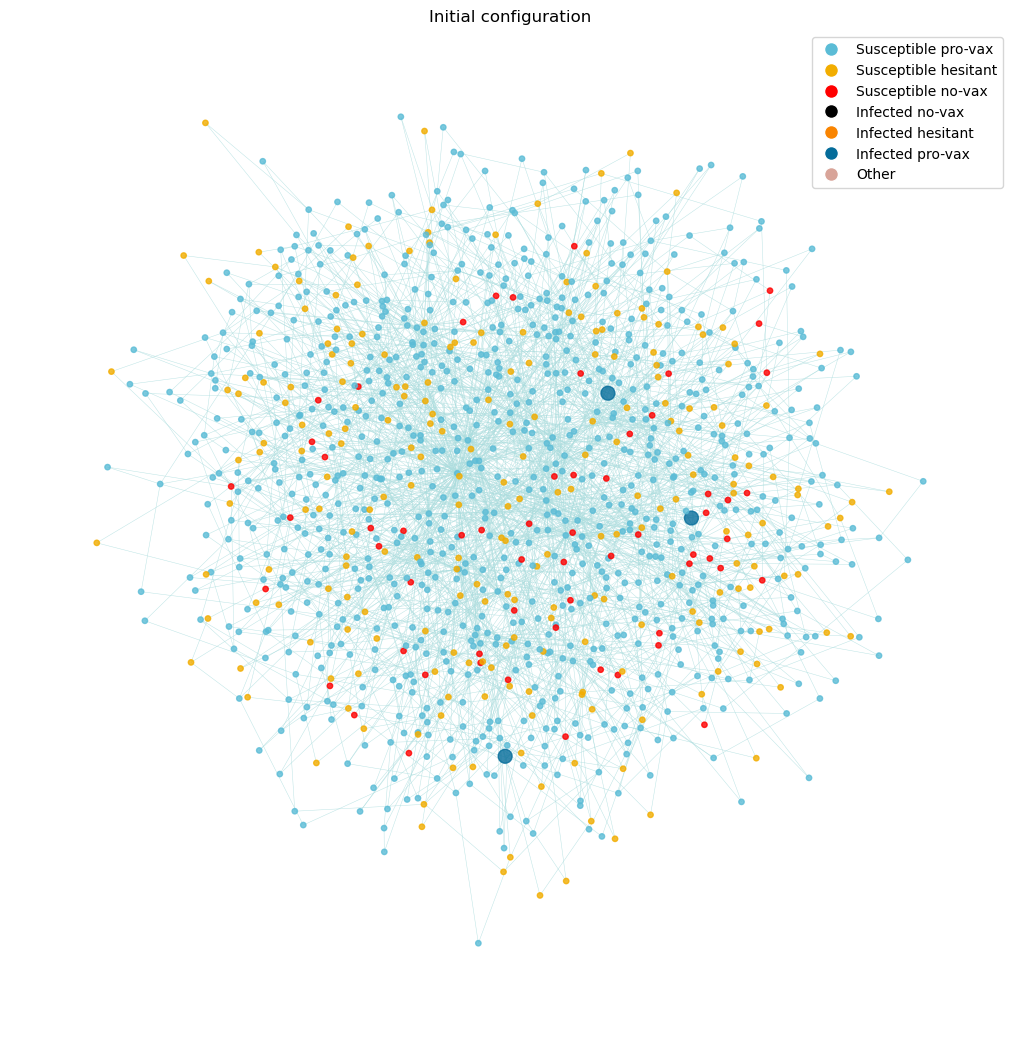

In [20]:
# plot the initial configuration
plt.figure(figsize=(10, 10))

# Define node colors based on states
node_colors = [
    '#5BBCD6' if s == 0 else
    '#FF0000' if s == 2 else
    '#F2AD00' if s == 1 else
    '#000000' if s == 3 else
    '#F98400' if s == 4 else
    '#046C9A' if s == 5 else
    '#D8A499' for s in state_init[:, 1]
]

# Define node size based on states
node_size = [
    100 if s in [3, 4, 5] else
    15 for s in state_init[:, 1]
]

# Draw the network 
nx.draw(
    G, 
    node_color=node_colors, 
    node_size=node_size, 
    alpha=0.8, 
    edge_color='#ABDDDE',
    width=0.35
)

plt.title('Initial configuration')

# legend
legend_labels = {
    0: 'Susceptible pro-vax',
    1: 'Susceptible hesitant',
    2: 'Susceptible no-vax',
    3: 'Infected no-vax',
    4: 'Infected hesitant',
    5: 'Infected pro-vax',
    'other': 'Other'
}

legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) 
    for color, label in zip(['#5BBCD6', '#F2AD00', '#FF0000', '#000000', '#F98400', '#046C9A', '#D8A499'], legend_labels.values())
]

plt.legend(handles=legend_elements, loc='best')
plt.savefig("net_hub.png")
plt.show()


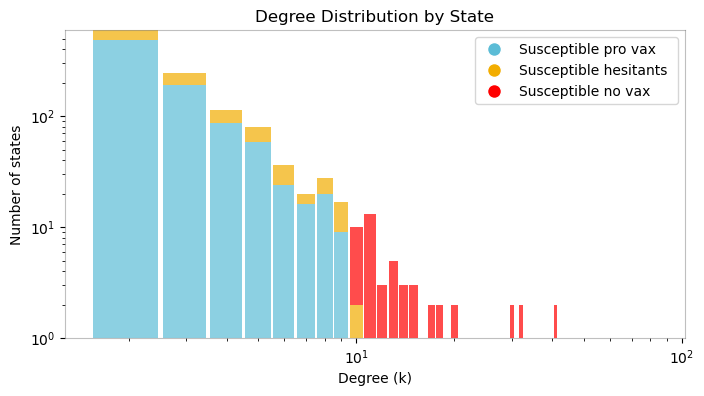

In [55]:
# Probability density function of the degrees in the network
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # sorted list of the degrees of all nodes
degree_seq_unique = np.unique(degree_sequence, return_counts=False)  # list of all possible degrees
degree_count = np.unique(degree_sequence, return_counts=True)  # frequency of each degree in the network

# state_degree --> [number of the node; state; degree]
N = G.number_of_nodes()
state_degree = np.zeros((N, 3))
for i, node in enumerate(G.nodes()):
    state_degree[i, 0] = node
    state_degree[i, 1] = init[i]
    state_degree[i, 2] = G.degree(node)

# Calculate the percentage of each state for each degree

percentage_by_degree = {}
for d in degree_seq_unique:
    perc_h, perc_n, perc_v, perc_other = 0, 0, 0, 0
    for i in range(N):
        if state_degree[i, 2] == d:
            if state_degree[i, 1] == 1:
                perc_h += 1
            elif state_degree[i, 1] == 2:
                perc_n += 1
            elif state_degree[i, 1] == 0:
                perc_v += 1
            else:
                perc_other += 1

    total_states = perc_h + perc_n + perc_v + perc_other
    total_states = 1
    if total_states > 0:
        percentage_by_degree[d] = (perc_v / total_states, perc_h / total_states, perc_n / total_states,
                                   perc_other / total_states)
        
        #print(perc_h , perc_v, perc_n)
    else:
        percentage_by_degree[d] = (0, 0, 0, 0)

# Plot the degree distribution with bars divided by colors
fig, ax = plt.subplots(figsize=(8,4))
bottom = np.zeros(len(degree_seq_unique))

for state in range(3):
    color ='#5BBCD6' if state == 0 else '#FF0000' if state == 2 else '#F2AD00' if state == 1 else '#000000' if state == 3 else '#F98400' if state == 4 else '#046C9A' if state == 5 else '#D8A499'
    state_percentages = np.array([percentage_by_degree[d][state] for d in degree_seq_unique])
    p = ax.bar(degree_seq_unique, state_percentages, 0.9, label=f"State {state}", bottom=bottom, color=color, alpha=0.7)
    bottom += state_percentages

ax.set_title("Degree Distribution by State")
ax.set_xlabel("Degree (k)")
ax.set_ylabel("Number of states")
plt.yscale("log")
plt.xscale("log")

legend_labels = {
    0: 'Susceptible pro vax ',
    1: 'Susceptible hesitants ',
    2: 'Susceptible no vax',
    #3: 'Infected no vax',
    #4: 'Infected hesitants',
    #5: 'Infected pro vax'
}
plt.gca().spines['top'].set_color('gray')  # Top spine
plt.gca().spines['right'].set_color('gray')  # Right spine
plt.gca().spines['bottom'].set_color('gray')  # Bottom spine
plt.gca().spines['left'].set_color('gray')  # Left spine

# Adjust the transparency (alpha) of the lines
for spine in plt.gca().spines.values():
    spine.set_alpha(0.5)
    
    
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
    for color, label in zip(['#5BBCD6', '#F2AD00',  '#FF0000', '#000000', '#F98400', '#046C9A', '#D8A499'], legend_labels.values())
]
ax.legend(handles=legend_elements, loc='best')
plt.savefig("Pk_hub.png")

plt.show()


## 2 - SIRV simulation on network

In [21]:
def iterate(G, vac_beta, beta, vac_mu, mu, d_no_vac,d_vac, tau_v, state, i_count,death_count, r_count, vaccine_available, weights):
    '''
    G = graph
    vac_beta = rate of infection for vaccinated people
    beta = rate of infection for non-vaccinated susceptible 
    mu = rate of recovery for non_vaccinated infectious
    state = conditions of each nodes (1/2/3/4/5/6)
    vac_beta = beta for vaccinated state 
    vac_mu = mu for vaccinated state
    d_vac = death rate for vax infected
    d_no_vac = death rate for no vax infected
    tau_v = waiting time for the vaccine to work
    '''
    
### -------------------------------------

    N = G.number_of_nodes()
    state_next = np.copy(state)
    adverse_count = 0
    r_vac_count = 0
    death_vac_count = 0 # vax death 9
    vaccine_count = 0   # cumulative number of vaccinet people
    v_adverse = 0.5  # rate of being vax with adverse reaction 
    w3, w4, w5, w8, w12, w13, w14 = 1., 1., 1. , 2., 1., 1., 1.  # weights for the summation of people that make hesitants change their mind
    v = 0.05
    
    for i in range(N):

        # recovery of pro vax infected people  
        if state[i, 1] == 5:  # if i is infected and vaccinated, it can recover with probability mu
            if np.random.uniform(0, 1) <= mu:
                # Check for death of vaccinated individuals
                if np.random.uniform(0, 1) <= d_vac:
                    state_next[i, 1] = 12  # death vax
                    death_vac_count +=1
                    death_count +=1
                else:
                    state_next[i, 1] = 9  # recovered pro-vax
                    r_vac_count += 1
                    
        # recovery of non-vaccinated people (non vax)
        elif state[i, 1] == 3:  # if i is infected and not vaccinated or hesitant
            if np.random.uniform(0, 1) <= mu:
                # Check for death of non-vaccinated individuals
                if np.random.uniform(0, 1) <= d_no_vac:
                    state_next[i, 1] = 14  # death no-vax
                    death_count +=1
                else:
                    state_next[i, 1] = 11  # recovered no-vax
                    r_count += 1
                    
        # recovery of non-vaccinated people (hesitant)
        elif state[i, 1] == 4:  # if i is infected and not vaccinated or hesitant
            if np.random.uniform(0, 1) <= mu:
                # Check for death of non-vaccinated individuals
                if np.random.uniform(0, 1) <= d_no_vac:
                    state_next[i, 1] = 13  # death no-vax
                    death_count +=1
                else:
                    state_next[i, 1] = 10  # recovered no-vax
                    r_count += 1
                    
        # from susc pro vax to pre vax 
        elif state[i, 1] == 0 and vaccine_count < vaccine_available:
                if np.random.uniform(0, 1) <= v:
                    state_next[i, 1] = 6
                    vaccine_count += 1

        # from susc pre vax to vax: VACCINATION
        elif state[i, 1] == 6 :
            if np.random.uniform(0, 1) <= 1/tau_v:
                if np.random.uniform(0, 1) <= v_adverse:
                        state_next[i, 1] = 8
                        adverse_count +=1
                else:
                    state_next[i, 1] = 7
 
        # infection   
        ## Changed the probability of getting infected based on the weights of neighbours
        elif state[i, 1] == 0 or state[i, 1] == 1 or state[i, 1] == 6  or state[i, 1] == 2:  # for all 4 conditions of susceptible
            neighbors_i = list(nx.all_neighbors(G, i))  # neighbors of i-th node
            states_neighbors_i = state[neighbors_i, 1]  # state of neighbors of i-th node

            total_weight = sum(G[i][j]['weight'] for j in neighbors_i)  # total weight of edges to all neighbors

            for j in neighbors_i:
                if state[j, 1] == 3 or state[j, 1] == 4 or state[j, 1] == 5: # if the neighbor is infected
                    neighbor_weight = G[i][j]['weight']  # Weight of edge to the infected neighbor
                    infection_rate = (beta * neighbor_weight) / total_weight

                    if np.random.uniform(0, 1) <= infection_rate:
                        if state[i, 1] == 0 or state[i, 1] == 6:
                            state_next[i, 1] = 5
                        elif state[i, 1] == 1:
                            state_next[i, 1] = 4
                        else:
                            state_next[i, 1] = 3  
                        i_count += 1
                        break  # stop checking the neighbor once already infected  

        elif state[i, 1] == 7 or state[i, 1] == 8:
            neighbors_i = list(nx.all_neighbors(G, i))  # neighbors of i-th node
            states_neighbors_i = state[neighbors_i, 1]  # state of neighbors of i-th node

            total_weight = sum(G[i][j]['weight'] for j in neighbors_i)  # total weight of edges to all neighbors

            for j in neighbors_i:
                if state[j, 1] == 3 or state[j, 1] == 4 or state[j, 1] == 5:  # if the neighbor is infected
                    neighbor_weight = G[i][j]['weight']  # Weight of edge to the infected neighbor
                    infection_rate = (vac_beta * neighbor_weight) / total_weight 

                    if np.random.uniform(0, 1) <= infection_rate:
                        state_next[i, 1] = 5
                        i_count += 1
                        break  # stop checking the neighbor once already infected  

        total_contribution = np.sum(((state[:, 1] == 3) + (state[:, 1] == 4) + (state[:, 1] == 5)) * weights[0]  + 
                                (state[:, 1] == 12) * weights[2] + ((state[:, 1] == 13) + (state[:, 1] == 14)) * weights[3] + 
                                (state[:, 1] == 8) * weights[1])/(weights[0]+weights[1]+weights[2]+weights[3])
        
        # from hesistant to pro vax
        # Calculate the fraction of infected individuals
        infected_fraction = np.sum((state[:, 1] == 3) | (state[:, 1] == 4) | (state[:, 1] == 5)) / 400


        if state[i, 1] == 1:  # if i is a susceptible hesitant node

            # Generate a random number between 0 and 1
            random_number = np.random.rand()
            
            # Compare the infected fraction to the random number
            if infected_fraction > random_number:
                neighbors_i = list(nx.all_neighbors(G, i))  # neighbors of i-th node
                states_neighbors_i = state[neighbors_i, 1]  # state of neighbors of i-th node
                
                
                count_ir = np.sum(
                    ((states_neighbors_i == 3) + (states_neighbors_i == 4) + (states_neighbors_i == 5)) * weights[0] +
                    (states_neighbors_i == 8) * weights[1] +
                    (states_neighbors_i == 12) * weights[2] +
                    ((states_neighbors_i == 13) + (states_neighbors_i == 14)) * weights[3]
                )/(weights[0]+weights[1]+weights[2]+weights[3])
    
    #             print('weights', count_ir/len(neighbors_i))
    
            #Factor to switch believe are from neighbours condition weighted and avg over neighbours + fraction of population that is infected, adverse reaction, and death
                decision = ((2/3)*count_ir/len(neighbors_i))+((1/3)*total_contribution/N)
                
                # Original threshold values
                threshold1 = 0.2
                threshold2 = 0.5
                threshold3 = 0.8
                
                # Standard deviation for Gaussian noise
                std_dev = 0.05  # Adjust this value as needed
                
                # Add Gaussian noise to the thresholds
                threshold1 += np.random.normal(scale=std_dev)
                threshold2 += np.random.normal(scale=std_dev)
                threshold3 += np.random.normal(scale=std_dev)
                
                # Ensure thresholds stay within valid range (0 to 1)
                threshold1 = np.clip(threshold1, 0, 1)
                threshold2 = np.clip(threshold2, 0, 1)
                threshold3 = np.clip(threshold3, 0, 1)
                
                # Decision variable (sample from a uniform distribution)
                decision = np.random.uniform()
                
                # Check decision against the stochastic thresholds
                if threshold1 < decision < threshold2:
                    state_next[i, 1] = 2  # change state to 2 (susceptible no vax)
                elif threshold3 < decision:
                    state_next[i, 1] = 0  # change state to 0 (susceptible pro vax)


    return state_next, i_count, r_count, r_vac_count, death_count, vaccine_count


In [22]:
def SIR_net(G, beta, mu, d_no_vac, d_vac, tau_v, i0, frac_hesitant, frac_novac, vaccine_time, doses, weights, draw):
    '''
    INPUT 
    G : a network
    beta : transmission per link
    mu : recovery rate
    initial_infecteds : node or iterable of nodes that will be infected at the beginning 
    d_vac = death rate for vax infected
    d_no_vac = death rate for no vax infected
    tau_v = waiting time for the vaccine to work
    i0 = number of infected intially
    frac_hesitant = fraction in population that is hesitant about vaccine (0 - 1)
    frac_novac = fraction in population that no vaccine (0 - 1)
    vaccine_time = time step to give vaccine
    doses = vaccine doses in population
    
    
    OUTPUT
    t,S,I,R numpy arrays with series of time steps, and series of number of infected, susceptible, recovered per time step
    i,r numpy arrays of number of nodes that just changed the state to infected, recovered per time step
    state_init numpy arrays of initial state
    state numpy arrays of final state
    '''
    
  
    vac_beta= beta*0.95 #changes of getting infected is lower after vaccination
    vac_mu = mu*1.1 
    i_count = 0
    adverse_count = 0
    death_count = 0
    r_count = 0
    
    
    ## Calling function to get state
    if periphery_init: 
        init_no_inf, init, state_init = periphery_in(i0, frac_hesitant, frac_novac, complex_contagion)
        
    if hubs_init:
        init_no_inf, init, state_init = hubs_in(i0, frac_hesitant, frac_novac, complex_contagion)
        
    if random_init:
        init_no_inf, init, state_init = random_in(i0, frac_hesitant, frac_novac, complex_contagion)
        
    
    # I am lazy to change all variables
    initial_infecteds = init
    state = state_init
        
    
    #state = get_state(G, initial_infecteds)

    T_steps = 500
    N = G.number_of_nodes()
    I, R, S, D, V = np.zeros(T_steps), np.zeros(T_steps), np.zeros(T_steps), np.zeros(T_steps), np.zeros(T_steps)
    I[0] = sum(initial_infecteds == 3) + sum(initial_infecteds == 4) + sum(initial_infecteds == 5)
    S[0] = sum(initial_infecteds == 1) + sum(initial_infecteds == 0) + sum(initial_infecteds == 2)
    
    T = np.arange(T_steps)
    

    i, r = np.zeros(T_steps), np.zeros(T_steps)

    for t in range(1, T_steps):
        
        if t > vaccine_time:  #after some timesteps, vaccine becomes available 
            vaccine_available = doses
        else:  #no vaccine yet
            vaccine_available = 0
        
        state_next, i_count_next, r_count_next, r_vac_count, death_count, vaccine_count = iterate(G, vac_beta, beta, vac_mu, mu, d_no_vac,d_vac, tau_v, state, i_count, death_count, r_count, vaccine_available, weights)
        i_count = i_count_next
        r_count = r_count_next
        state = state_next
        
        S[t] = np.sum(state[:, 1] == 1) + np.sum(state[:, 1] == 2) +  np.sum(state[:, 1] == 0)  
        I[t] = np.sum(state[:, 1] == 3) + np.sum(state[:, 1] == 4) + np.sum(state[:, 1] == 5)
        R[t] = np.sum(state[:, 1] == 9) + np.sum(state[:, 1] == 10) + np.sum(state[:, 1] == 11)
        D[t] = np.sum(state[:, 1] == 12) + np.sum(state[:, 1] == 13) + np.sum(state[:, 1] == 14)
        V[t] = np.sum(state[:, 1] == 7) + np.sum(state[:, 1] == 8)
        i[t] = i_count
        r[t] = r_count + r_vac_count
        
        if draw and t % 100 == 0:
            plt.figure()
            node_colors = ['yellow' if s == 1 else 'blue' if s == 2 else 'red' for s in state[:, 1]]
            nx.draw(G, node_color=node_colors, node_size=25, alpha=0.8, edge_color='black', width=0.35)
            plt.title(f'Time Step {t}')
            plt.show()

    return (S, I, R, D, V, T, state_init, state, i, r)
 

In [52]:
beta = 0.18
mu = 0.037
d_no_vac = 0.05
d_vac = 0.01
tau_v = 12
i0 = 3
frac_hesitant = 0.2
frac_novac = 0.05
vaccine_time = 120
doses = 500


weights = [1., 3., 2., 3.] 

S, I, R, D, V, T, state_init, state, i, r = SIR_net(G, beta, mu, d_no_vac, d_vac, tau_v, i0, frac_hesitant, frac_novac, vaccine_time, doses, weights, draw=False)

random


## Gridsearch for best weight with both inf + death

In [25]:
import time 
import itertools
from multiprocessing import Pool

start_time = time.time()

# Define your parameters
beta = 0.18
mu = 0.037
d_no_vac = 0.05
d_vac = 0.01
tau_v = 12
i0 = 3
frac_hesitant = 0.2
frac_novac = 0.05
vaccine_time = 120
doses = 500

# Weight values
w_infected_values = [0.6 , 0.7 , 0.8 ]
w_adv_reaction_values = [0.7 ,0.8 ,0.9 ]
w_vax_death = [0.85 ,0.9 ,0.95]
w_no_vax_death = [0.4 , 0.5 , 0.6]

# Generate all possible combinations of weights
weight_combinations = list(itertools.product(w_infected_values, w_adv_reaction_values, w_vax_death, w_no_vax_death))

# Function to run the simulation
def simulate(weights):
    num_sim = 30
    all_I = np.zeros((num_sim, 500))
    all_D = np.zeros((num_sim, 500))

    non_included = 0

    for sim in range(num_sim):
        # Assuming SIR_net is defined elsewhere
        S, I, R, D, V, T, state_init, state, i, r = SIR_net(
            G, beta, mu, d_no_vac, d_vac, tau_v, i0, frac_hesitant, frac_novac, vaccine_time, doses, weights, draw=False
        )

        if I[100] <= 10:
            non_included += 1
        else:
            all_I[sim, :] = I
            all_D[sim, :] = D
            
    # Calculate the average peak infected individuals over all simulations
    peak_infected = np.mean(np.max(all_I, axis=1))
    
    # Calculate the average number of final deaths individuals over all simulations
    max_deaths = np.mean(np.max(all_D, axis=1))
    
    return weights, peak_infected, max_deaths

# Parallelize the simulations using joblib
n_jobs = -1  # Uses all available CPU cores
simulation_results = Parallel(n_jobs=n_jobs)(delayed(simulate)(weights) for weights in weight_combinations)


# Process the simulation results
results_weights = {weights: (peak_infected, max_deaths) for weights, peak_infected, max_deaths in simulation_results}

# Find the best weights and metric for peak infected
best_metric_infected = float('inf')
best_weights_infected = None
for weights, (peak_infected, _) in results_weights.items():
    if peak_infected < best_metric_infected:
        best_metric_infected = peak_infected
        best_weights_infected = weights

# Find the best weights and metric for deaths
best_metric_deaths = float('inf')
best_weights_deaths = None
for weights, (_, max_deaths) in results_weights.items():
    if max_deaths < best_metric_deaths:
        best_metric_deaths = max_deaths
        best_weights_deaths = weights

# Find the weights for the median peak infected value
peak_infected_values = [result[1] for result in simulation_results]
median_peak_infected = np.median(peak_infected_values)
closest_median_infected = min(simulation_results, key=lambda x: abs(x[1] - median_peak_infected))
median_weights_infected = closest_median_infected[0]
median_metric_infected = closest_median_infected[1]

# Find the weights for the median deaths value
max_deaths_values = [result[2] for result in simulation_results]
median_max_deaths = np.median(max_deaths_values)
closest_median_deaths = min(simulation_results, key=lambda x: abs(x[2] - median_max_deaths))
median_weights_deaths = closest_median_deaths[0]
median_metric_deaths = closest_median_deaths[2]

print("Best weights for peak infected:", best_weights_infected)
print("Best metric for peak infected:", best_metric_infected)

print("Best weights for deaths:", best_weights_deaths)
print("Best metric for deaths:", best_metric_deaths)

print("Median weights for peak infected:", median_weights_infected)
print("Median metric for peak infected:", median_metric_infected)

print("Median weights for deaths:", median_weights_deaths)
print("Median metric for deaths:", median_metric_deaths)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")


random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random

Best weights for peak infected: (0.8, 0.9, 0.85, 0.5)
Best metric for peak infected: 184.8
Best weights for deaths: (0.7, 0.8, 0.9, 0.6)
Best metric for deaths: 10.466666666666667
Median weights for peak infected: (0.6, 0.7, 0.95, 0.4)
Median metric for peak infected: 236.2
Median weights for deaths: (0.6, 0.8, 0.95, 0.4)
Median metric for deaths: 13.633333333333333
Elapsed time: 8554.506682634354 seconds


In [26]:
results_weights

{(0.6, 0.7, 0.85, 0.4): (274.93333333333334, 14.033333333333333),
 (0.6, 0.7, 0.85, 0.5): (224.5, 12.933333333333334),
 (0.6, 0.7, 0.85, 0.6): (235.53333333333333, 13.3),
 (0.6, 0.7, 0.9, 0.4): (243.33333333333334, 15.733333333333333),
 (0.6, 0.7, 0.9, 0.5): (228.33333333333334, 12.866666666666667),
 (0.6, 0.7, 0.9, 0.6): (250.26666666666668, 13.733333333333333),
 (0.6, 0.7, 0.95, 0.4): (236.2, 14.0),
 (0.6, 0.7, 0.95, 0.5): (238.4, 13.133333333333333),
 (0.6, 0.7, 0.95, 0.6): (249.4, 12.533333333333333),
 (0.6, 0.8, 0.85, 0.4): (271.56666666666666, 14.933333333333334),
 (0.6, 0.8, 0.85, 0.5): (211.33333333333334, 13.466666666666667),
 (0.6, 0.8, 0.85, 0.6): (260.06666666666666, 15.733333333333333),
 (0.6, 0.8, 0.9, 0.4): (268.73333333333335, 14.266666666666667),
 (0.6, 0.8, 0.9, 0.5): (213.96666666666667, 11.4),
 (0.6, 0.8, 0.9, 0.6): (216.7, 12.2),
 (0.6, 0.8, 0.95, 0.4): (216.4, 13.633333333333333),
 (0.6, 0.8, 0.95, 0.5): (216.53333333333333, 14.4),
 (0.6, 0.8, 0.95, 0.6): (275.766

##### save results

In [27]:
# Save results in dictionary for peak infected
with open('results_inf_official.txt', 'w') as file:
    for key, (peak_infected, _) in results_weights.items():
        file.write(f"Parameters: w_infected={key[0]}, w_adv_reaction={key[1]}, w_vax_death={key[2]}, w_no_vax_death={key[3]}\n")
        file.write(f"Peak Infected: {peak_infected}\n")
        file.write("\n")
        
# Save results in dictionary for peak deaths
with open('results_deaths_official.txt', 'w') as file:
    for key, (_, peak_deaths) in results_weights.items():
        file.write(f"Parameters: w_infected={key[0]}, w_adv_reaction={key[1]}, w_vax_death={key[2]}, w_no_vax_death={key[3]}\n")
        file.write(f"Peak deaths: {peak_deaths}\n")
        file.write("\n")



random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random

#####  Plot them

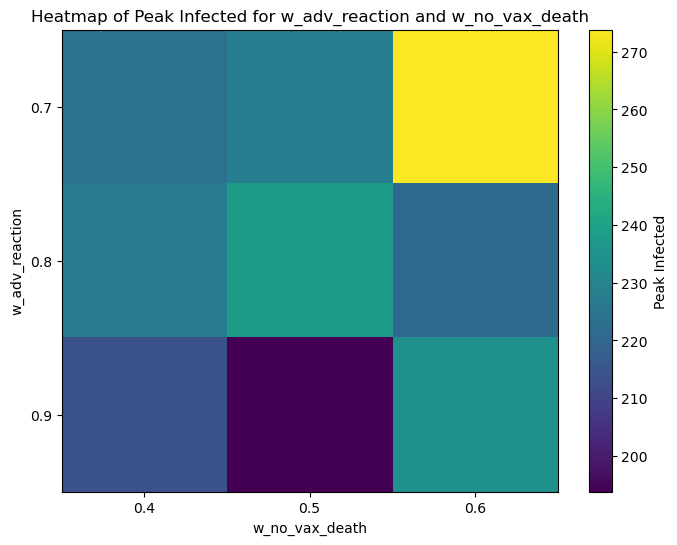

In [29]:
# Read the data from the file
results = {}
with open('results_inf_official.txt', 'r') as file:
    for line in file:
        if line.startswith('Parameters:'):
            params = line.strip().split(', ')
            w_infected = float(params[0].split('=')[1])
            w_adv_reaction = float(params[1].split('=')[1])
            w_vax_death = float(params[2].split('=')[1])
            w_no_vax_death = float(params[3].split('=')[1])
        elif line.startswith('Peak Infected:'):
            peak_infected = float(line.split(': ')[1])
            results[(w_adv_reaction, w_no_vax_death)] = peak_infected

# Create lists of unique values for the two weights
w_adv_reaction_values = sorted(set(key[0] for key in results.keys()))
w_no_vax_death_values = sorted(set(key[1] for key in results.keys()))

# Create a matrix to store the peak infected values
heatmap_data = np.zeros((len(w_adv_reaction_values), len(w_no_vax_death_values)))

# Fill the matrix with the peak infected values
for idx_adv, w_adv_reaction in enumerate(w_adv_reaction_values):
    for idx_nv, w_no_vax_death in enumerate(w_no_vax_death_values):
        heatmap_data[idx_adv, idx_nv] = results.get((w_adv_reaction, w_no_vax_death), np.nan)

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(heatmap_data, cmap='viridis', interpolation='nearest', aspect='auto')
plt.colorbar(label='Peak Infected')
plt.xticks(ticks=np.arange(len(w_no_vax_death_values)), labels=w_no_vax_death_values)
plt.yticks(ticks=np.arange(len(w_adv_reaction_values)), labels=w_adv_reaction_values)
plt.xlabel('w_no_vax_death')
plt.ylabel('w_adv_reaction')
plt.title('Heatmap of Peak Infected for w_adv_reaction and w_no_vax_death')
plt.show()


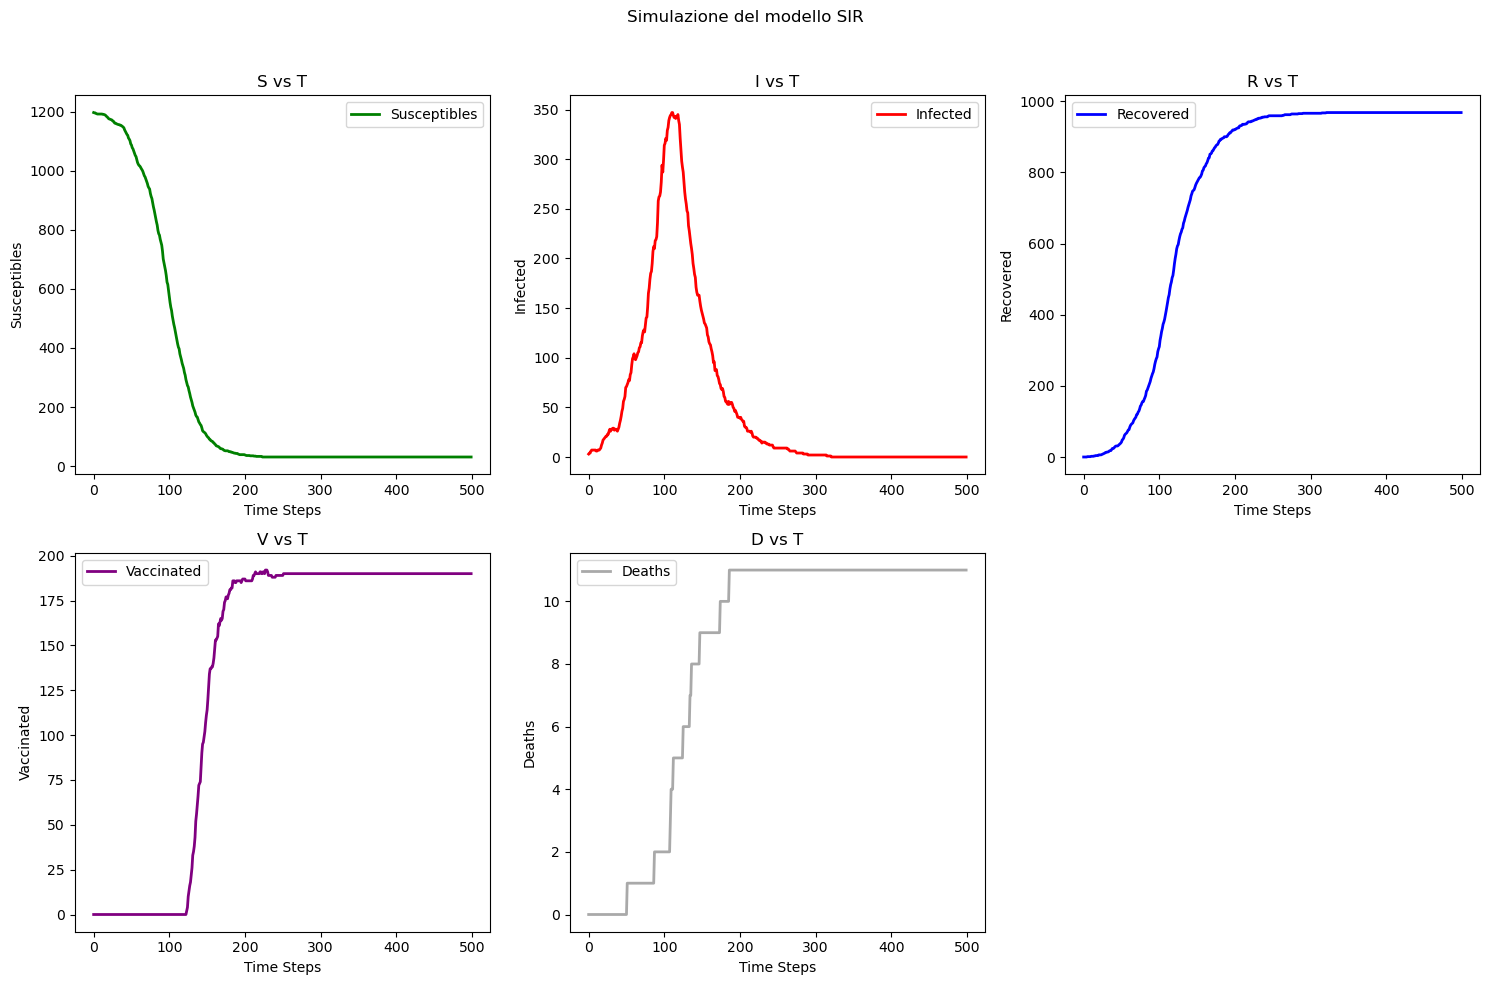

In [53]:
# griglia di subplot 2x3
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Plot di S vs T
axs[0, 0].plot(T, S, color='green', label='Susceptibles', linewidth=2)
axs[0, 0].set_xlabel('Time Steps')
axs[0, 0].set_ylabel('Susceptibles')
axs[0, 0].legend()
axs[0, 0].set_title('S vs T')

# Plot di I vs T
axs[0, 1].plot(T, I, color='red', label='Infected', linewidth=2)
axs[0, 1].set_xlabel('Time Steps')
axs[0, 1].set_ylabel('Infected')
axs[0, 1].legend()
axs[0, 1].set_title('I vs T')

# Plot di R vs T
axs[0, 2].plot(T, R, color='blue', label='Recovered', linewidth=2)
axs[0, 2].set_xlabel('Time Steps')
axs[0, 2].set_ylabel('Recovered')
axs[0, 2].legend()
axs[0, 2].set_title('R vs T')

# Plot di V vs T
axs[1, 0].plot(T, V, color='purple', label='Vaccinated', linewidth=2)
axs[1, 0].set_xlabel('Time Steps')
axs[1, 0].set_ylabel('Vaccinated')
axs[1, 0].legend()
axs[1, 0].set_title('V vs T')

# Plot di D vs T
axs[1, 1].plot(T, D, color='darkgray', label='Deaths', linewidth=2)
axs[1, 1].set_xlabel('Time Steps')
axs[1, 1].set_ylabel('Deaths')
axs[1, 1].legend()
axs[1, 1].set_title('D vs T')

fig.delaxes(axs[1, 2])

fig.suptitle('Simulazione del modello SIR')

fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Sensitivity analysis random init, varying i0

In [49]:
### To simulate many i0

# Initialize your parameters
beta = 0.18
mu = 0.037
d_no_vac = 0.05
d_vac = 0.01
tau_v = 12
i0_values = [1, 3, 5, 10, 20, 50, 100, 150, 200, 300]
frac_hesitant_values = [0.2]
frac_novac_values = [0.05]
vaccine_time = 120
doses = 500
weights = [0.6, 0.75, 0.95, 0.4] ## random
#Median weights for peak infected: (0.6, 0.7, 0.95, 0.4)
#Median weights for deaths: (0.6, 0.8, 0.95, 0.4)

# Define the simulation function
def simulate(i0, frac_hesitant, frac_novac):
    num_sim = 100
    num_steps = 500
    all_S = np.zeros((num_sim, num_steps))
    all_I = np.zeros((num_sim, num_steps))
    all_R = np.zeros((num_sim, num_steps))
    all_V = np.zeros((num_sim, num_steps))
    all_D = np.zeros((num_sim, num_steps))
    non_included = 0

    for sim in range(num_sim):
        S, I, R, D, V, T, state_init, state, i, r = SIR_net(
            G, beta, mu, d_no_vac, d_vac, tau_v, i0, frac_hesitant,
            frac_novac, vaccine_time, doses, weights, draw=False
        )

        if I[100] == 0:
            non_included += 1
        else:
            all_S[sim, :] = S
            all_I[sim, :] = I
            all_R[sim, :] = R
            all_V[sim, :] = V
            all_D[sim, :] = D

    if non_included < num_sim:
        # Calculate means
        means = {
            'S': np.sum(all_S, axis=0) / (num_sim - non_included),
            'I': np.sum(all_I, axis=0) / (num_sim - non_included),
            'R': np.sum(all_R, axis=0) / (num_sim - non_included),
            'V': np.sum(all_V, axis=0) / (num_sim - non_included),
            'D': np.sum(all_D, axis=0) / (num_sim - non_included),         
        }
        # Calculate standard deviations
        stds = {
            'S': np.std(all_S, axis=0),
            'I': np.std(all_I, axis=0),
            'R': np.std(all_R, axis=0),
            'V': np.std(all_V, axis=0),
            'D': np.std(all_D, axis=0),
        }
        return means, stds
    else:
        return None

# Function to run simulations for a single i0 value
def run_simulation_for_i0(i0):
    results_for_i0 = {}
    for frac_hesitant in frac_hesitant_values:
        for frac_novac in frac_novac_values:
            result = simulate(i0, frac_hesitant, frac_novac)
            if result is not None:
                results_for_i0[(i0, frac_hesitant, frac_novac)] = result
    return results_for_i0

# Use joblib to parallelize across i0 values
all_results = Parallel(n_jobs=-1)(
    delayed(run_simulation_for_i0)(i0) for i0 in i0_values
)

# Combine results from different i0 values
results = {}
for single_result in all_results:
    results.update(single_result)

# Optional: Print or process the results
for key, value in results.items():
    print(f"{key}: {value}")


random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


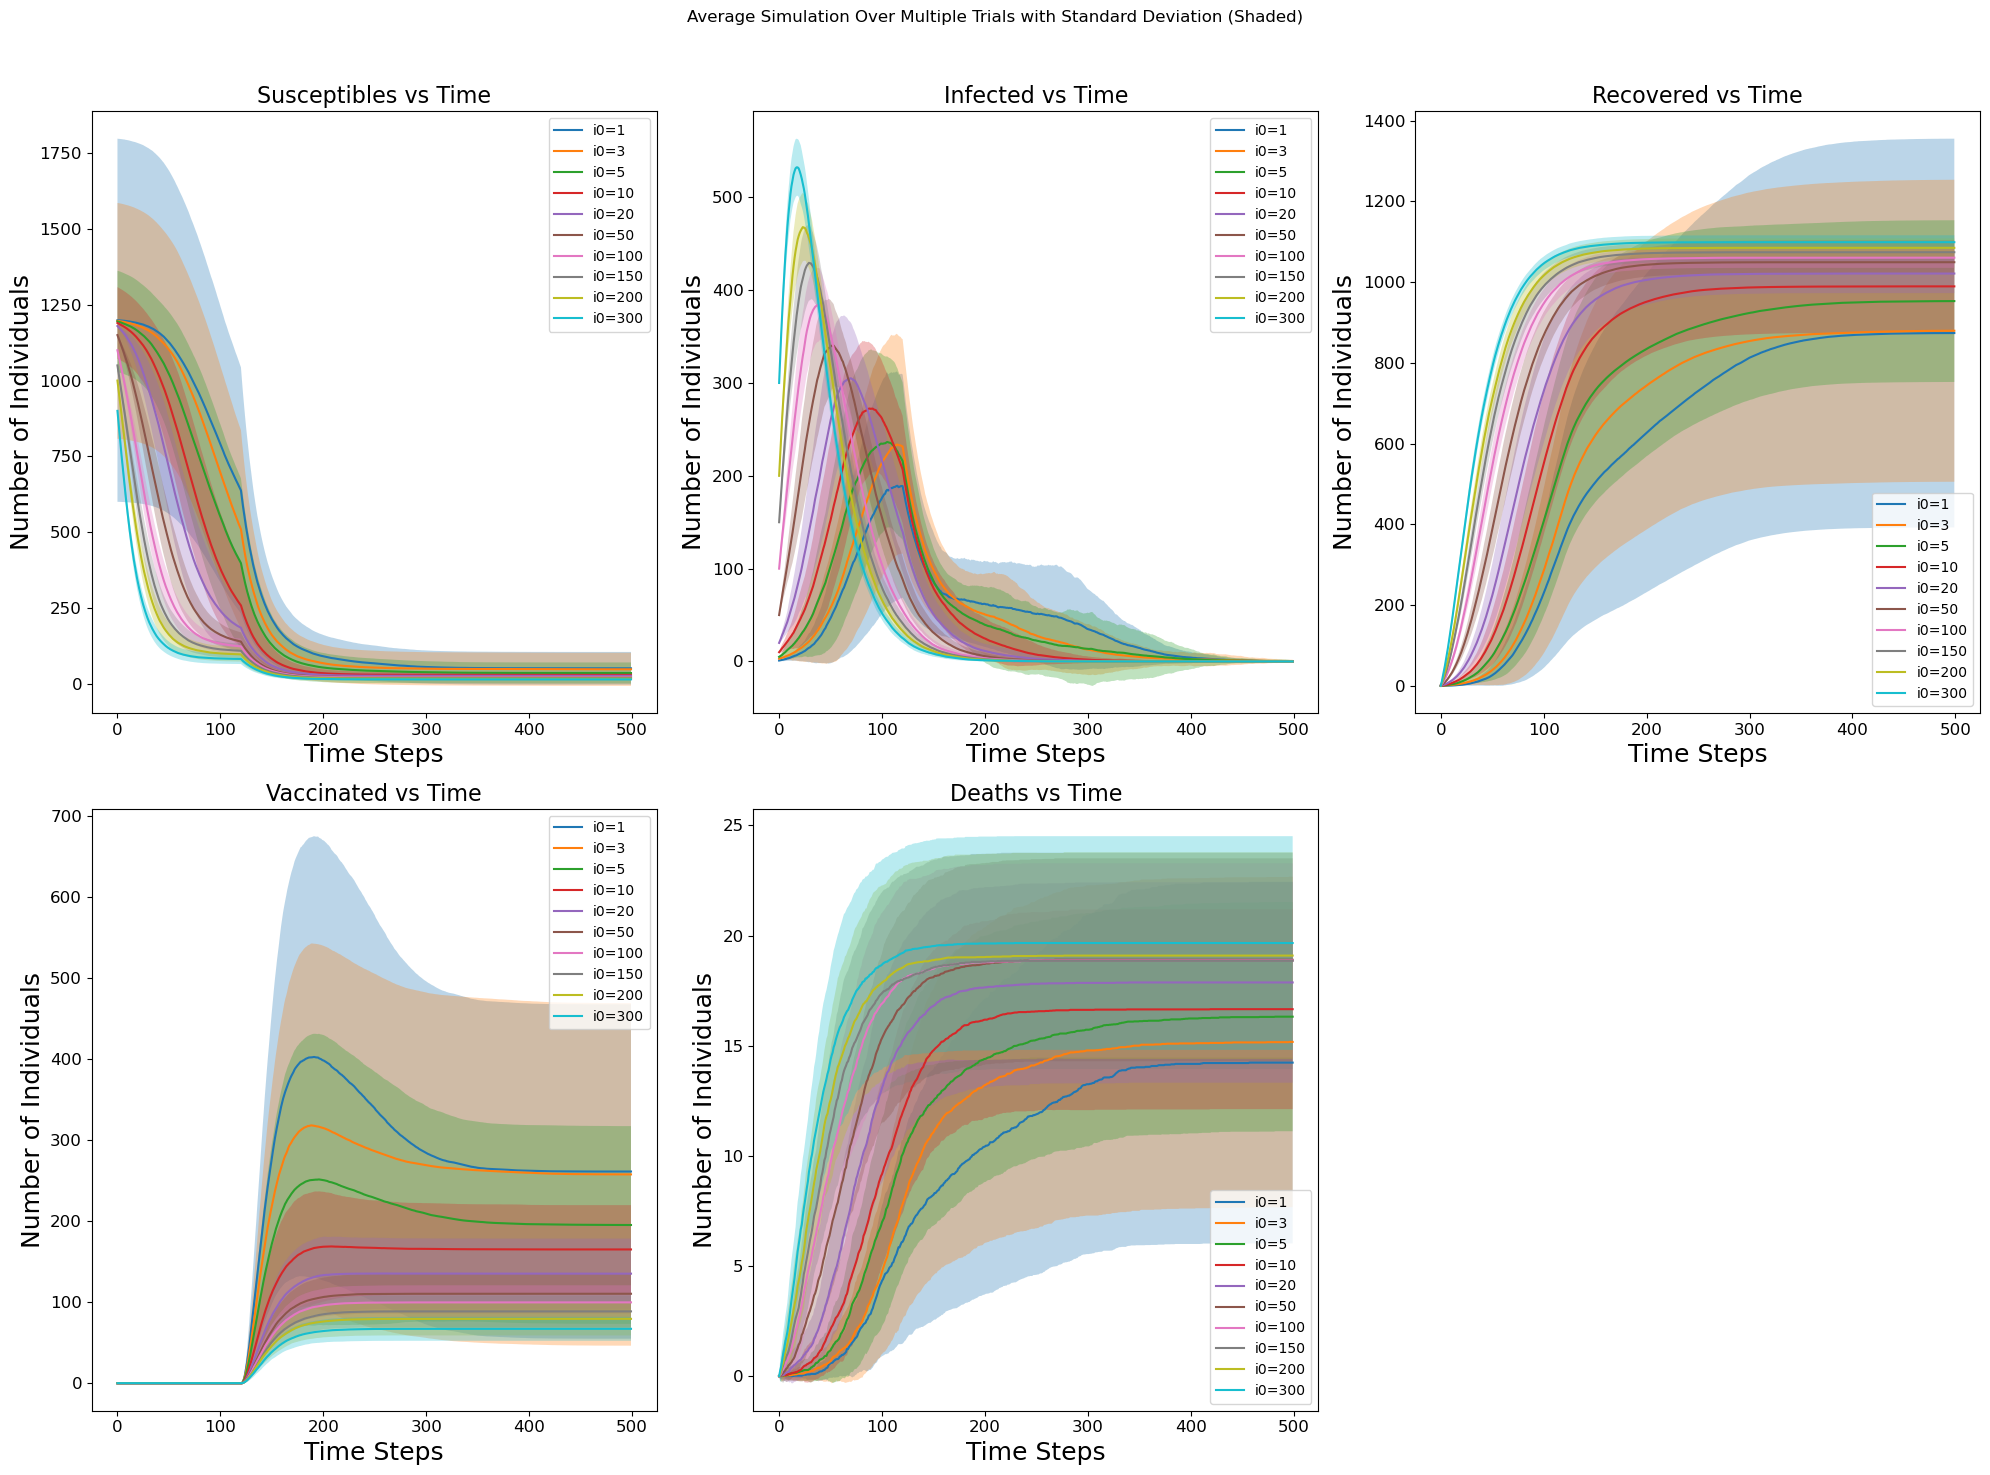

In [58]:

# Plotting with shaded regions for standard deviation
fig, axs = plt.subplots(2, 3, figsize=(20,15))
num_steps = 500

for key, value in results.items():
    i0_value = key[0]  # Extracting the i0 value from the key tuple
    average_results, std_results = value  # Unpacking the tuple value
    
    # Susceptibles vs Time
    axs[0, 0].plot(average_results['S'], label=f'i0={i0_value}')
    axs[0, 0].fill_between(range(num_steps), 
                            average_results['S'] - std_results['S'], 
                            average_results['S'] + std_results['S'], 
                            alpha=0.3)
    axs[0, 0].set_title('S vs T')


    # Infected vs Time
    axs[0, 1].plot(average_results['I'], label=f'i0={i0_value}')
    axs[0, 1].fill_between(range(num_steps), 
                            average_results['I'] - std_results['I'], 
                            average_results['I'] + std_results['I'], 
                            alpha=0.3)
    axs[0, 1].set_title('I vs T')


    # Recovered vs Time
    axs[0, 2].plot(average_results['R'], label=f'i0={i0_value}')
    axs[0, 2].fill_between(range(num_steps), 
                            average_results['R'] - std_results['R'], 
                            average_results['R'] + std_results['R'], 
                            alpha=0.3)
    axs[0, 2].set_title('R vs T')


    # Vaccinated vs Time
    axs[1, 0].plot(average_results['V'], label=f'i0={i0_value}')
    axs[1, 0].fill_between(range(num_steps), 
                            average_results['V'] - std_results['V'], 
                            average_results['V'] + std_results['V'], 
                            alpha=0.3)
    axs[1, 0].set_title('V vs T')

    # Deaths vs Time
    axs[1, 1].plot(average_results['D'], label=f'i0={i0_value}')
    axs[1, 1].fill_between(range(num_steps), 
                            average_results['D'] - std_results['D'], 
                            average_results['D'] + std_results['D'], 
                            alpha=0.3)
    axs[1, 1].set_title('D vs T')


# Adjust labels, legend, and layout
for ax in axs.flat:
    ax.set_xlabel('Time Steps', fontsize=18)  # Increase font size of x-axis label
    ax.set_ylabel('Number of Individuals', fontsize=18)  # Increase font size of y-axis label
    ax.legend()
    ax.tick_params(axis='both', which='major', labelsize=12)  # Increase font size of tick labels

# Set titles of plots
axs[0, 0].set_title('Susceptibles vs Time', fontsize=16)
axs[0, 1].set_title('Infected vs Time', fontsize=16)
axs[0, 2].set_title('Recovered vs Time', fontsize=16)
axs[1, 0].set_title('Vaccinated vs Time', fontsize=16)
axs[1, 1].set_title('Deaths vs Time', fontsize=16)

# Remove the unused subplot
fig.delaxes(axs[1, 2])

# Final adjustments and show plot
fig.suptitle('Average Simulation Over Multiple Trials with Standard Deviation (Shaded)')
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("sensitivity_random_i0.png")
plt.show()


In [51]:
def extract_metrics(results):
    peak_I_values = []
    start_epidemic_values = []
    max_deaths_values = []
    cumulative_infections_values = []

    for key, value in results.items():
        i0_value = key[0]  # Extracting the i0 value from the key tuple
        average_results, _ = value  # Unpacking the tuple value

        # Extracting metrics from the mean results
        peak_I = np.max(average_results['I'])
        start_epidemic = next((t for t, I in enumerate(average_results['I']) if I > 50), None)
        max_deaths = np.max(average_results['D'])
        cumulative_infections = np.sum(average_results['I'] + average_results['R'] + average_results['D'])

        # Append extracted metrics to respective lists
        peak_I_values.append(peak_I)
        start_epidemic_values.append(start_epidemic)
        max_deaths_values.append(max_deaths)
        cumulative_infections_values.append(cumulative_infections)

    # Print the extracted metrics vs their i0 values
    print("i0\tPeak of I\tStart of Epidemic\tMax Deaths\tCumulative Infections")
    for i0, peak_I, start_epidemic, max_deaths, cumulative_infections in zip(results.keys(), peak_I_values, start_epidemic_values, max_deaths_values, cumulative_infections_values):
        print(f"{i0}\t{peak_I}\t{start_epidemic}\t{max_deaths}\t{cumulative_infections}")

extract_metrics(results)


i0	Peak of I	Start of Epidemic	Max Deaths	Cumulative Infections
(1, 0.2, 0.05)	189.25	52	14.23076923076923	326983.6153846154
(3, 0.2, 0.05)	233.5909090909091	47	15.170454545454545	350647.4431818182
(5, 0.2, 0.05)	236.4591836734694	33	16.316326530612244	391258.24489795923
(10, 0.2, 0.05)	272.4848484848485	23	16.656565656565657	429333.7070707071
(20, 0.2, 0.05)	305.03	10	17.87	461763.56
(50, 0.2, 0.05)	340.21	1	18.9	491245.32
(100, 0.2, 0.05)	384.65	0	18.87	508789.23
(150, 0.2, 0.05)	429.4	0	18.85	522357.1099999999
(200, 0.2, 0.05)	467.85	0	19.09	532497.22
(300, 0.2, 0.05)	532.31	0	19.66	545221.31
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
rando

# Sensitivity analysis random init, varying hesitants

In [49]:
### To simulate many hes

# Initialize your parameters
beta = 0.18
mu = 0.037
d_no_vac = 0.05
d_vac = 0.01
tau_v = 12
i0_values = [3]
frac_hesitant_values  = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.7, 0.9] 

frac_novac_values = [0.05]
vaccine_time = 120
doses = 500
weights = [0.6, 0.75, 0.95, 0.4] ## random
#Median weights for peak infected: (0.6, 0.7, 0.95, 0.4)
#Median weights for deaths: (0.6, 0.8, 0.95, 0.4)

# Define the simulation function
def simulate(i0, frac_hesitant, frac_novac):
    num_sim = 100
    num_steps = 500
    all_S = np.zeros((num_sim, num_steps))
    all_I = np.zeros((num_sim, num_steps))
    all_R = np.zeros((num_sim, num_steps))
    all_V = np.zeros((num_sim, num_steps))
    all_D = np.zeros((num_sim, num_steps))
    non_included = 0

    for sim in range(num_sim):
        S, I, R, D, V, T, state_init, state, i, r = SIR_net(
            G, beta, mu, d_no_vac, d_vac, tau_v, i0, frac_hesitant,
            frac_novac, vaccine_time, doses, weights, draw=False
        )

        if I[100] == 0:
            non_included += 1
        else:
            all_S[sim, :] = S
            all_I[sim, :] = I
            all_R[sim, :] = R
            all_V[sim, :] = V
            all_D[sim, :] = D

    if non_included < num_sim:
        # Calculate means
        means = {
            'S': np.sum(all_S, axis=0) / (num_sim - non_included),
            'I': np.sum(all_I, axis=0) / (num_sim - non_included),
            'R': np.sum(all_R, axis=0) / (num_sim - non_included),
            'V': np.sum(all_V, axis=0) / (num_sim - non_included),
            'D': np.sum(all_D, axis=0) / (num_sim - non_included),         
        }
        # Calculate standard deviations
        stds = {
            'S': np.std(all_S, axis=0),
            'I': np.std(all_I, axis=0),
            'R': np.std(all_R, axis=0),
            'V': np.std(all_V, axis=0),
            'D': np.std(all_D, axis=0),
        }
        return means, stds
    else:
        return None

# Function to run simulations for a single i0 value
def run_simulation_for_i0(i0):
    results_for_i0 = {}
    for frac_hesitant in frac_hesitant_values:
        for frac_novac in frac_novac_values:
            result = simulate(i0, frac_hesitant, frac_novac)
            if result is not None:
                results_for_i0[(i0, frac_hesitant, frac_novac)] = result
    return results_for_i0

# Use joblib to parallelize across i0 values
all_results = Parallel(n_jobs=-1)(
    delayed(run_simulation_for_i0)(i0) for i0 in i0_values
)

# Combine results from different i0 values
results = {}
for single_result in all_results:
    results.update(single_result)

# Optional: Print or process the results
for key, value in results.items():
    print(f"{key}: {value}")


random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


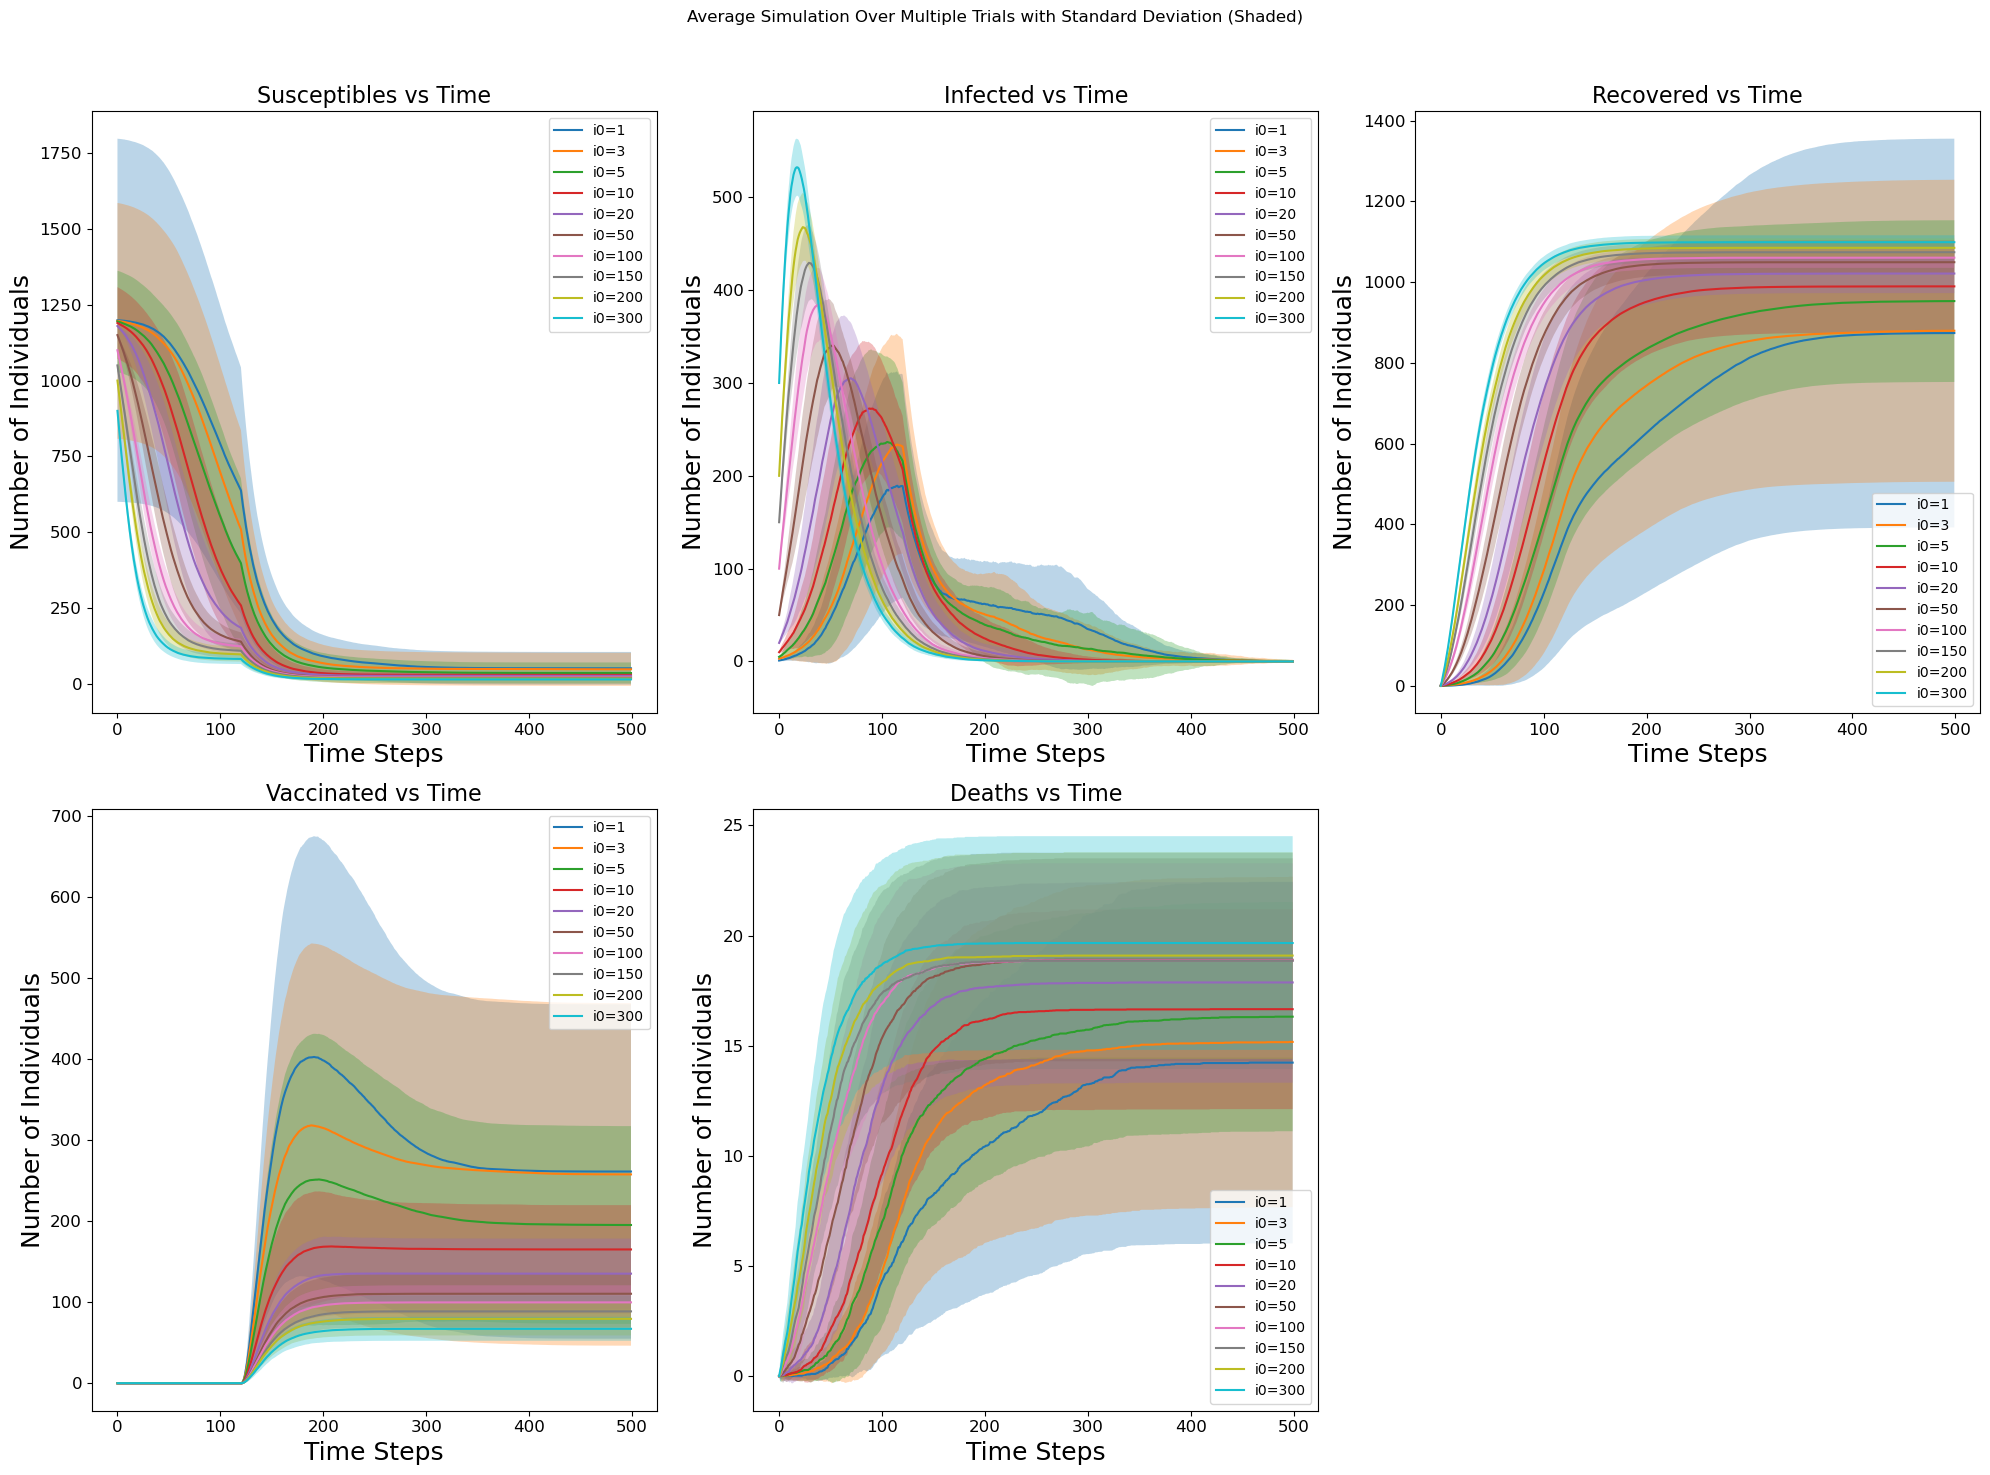

In [58]:

# Plotting with shaded regions for standard deviation
fig, axs = plt.subplots(2, 3, figsize=(20,15))
num_steps = 500

for key, value in results.items():
    i0_value = key[0]  # Extracting the i0 value from the key tuple
    average_results, std_results = value  # Unpacking the tuple value
    
    # Susceptibles vs Time
    axs[0, 0].plot(average_results['S'], label=f'i0={i0_value}')
    axs[0, 0].fill_between(range(num_steps), 
                            average_results['S'] - std_results['S'], 
                            average_results['S'] + std_results['S'], 
                            alpha=0.3)
    axs[0, 0].set_title('S vs T')


    # Infected vs Time
    axs[0, 1].plot(average_results['I'], label=f'i0={i0_value}')
    axs[0, 1].fill_between(range(num_steps), 
                            average_results['I'] - std_results['I'], 
                            average_results['I'] + std_results['I'], 
                            alpha=0.3)
    axs[0, 1].set_title('I vs T')


    # Recovered vs Time
    axs[0, 2].plot(average_results['R'], label=f'i0={i0_value}')
    axs[0, 2].fill_between(range(num_steps), 
                            average_results['R'] - std_results['R'], 
                            average_results['R'] + std_results['R'], 
                            alpha=0.3)
    axs[0, 2].set_title('R vs T')


    # Vaccinated vs Time
    axs[1, 0].plot(average_results['V'], label=f'i0={i0_value}')
    axs[1, 0].fill_between(range(num_steps), 
                            average_results['V'] - std_results['V'], 
                            average_results['V'] + std_results['V'], 
                            alpha=0.3)
    axs[1, 0].set_title('V vs T')

    # Deaths vs Time
    axs[1, 1].plot(average_results['D'], label=f'i0={i0_value}')
    axs[1, 1].fill_between(range(num_steps), 
                            average_results['D'] - std_results['D'], 
                            average_results['D'] + std_results['D'], 
                            alpha=0.3)
    axs[1, 1].set_title('D vs T')


# Adjust labels, legend, and layout
for ax in axs.flat:
    ax.set_xlabel('Time Steps', fontsize=18)  # Increase font size of x-axis label
    ax.set_ylabel('Number of Individuals', fontsize=18)  # Increase font size of y-axis label
    ax.legend()
    ax.tick_params(axis='both', which='major', labelsize=12)  # Increase font size of tick labels

# Set titles of plots
axs[0, 0].set_title('Susceptibles vs Time', fontsize=16)
axs[0, 1].set_title('Infected vs Time', fontsize=16)
axs[0, 2].set_title('Recovered vs Time', fontsize=16)
axs[1, 0].set_title('Vaccinated vs Time', fontsize=16)
axs[1, 1].set_title('Deaths vs Time', fontsize=16)

# Remove the unused subplot
fig.delaxes(axs[1, 2])

# Final adjustments and show plot
fig.suptitle('Average Simulation Over Multiple Trials with Standard Deviation (Shaded)')
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("sensitivity_random_i0.png")
plt.show()


In [51]:
def extract_metrics(results):
    peak_I_values = []
    start_epidemic_values = []
    max_deaths_values = []
    cumulative_infections_values = []

    for key, value in results.items():
        i0_value = key[0]  # Extracting the i0 value from the key tuple
        average_results, _ = value  # Unpacking the tuple value

        # Extracting metrics from the mean results
        peak_I = np.max(average_results['I'])
        start_epidemic = next((t for t, I in enumerate(average_results['I']) if I > 50), None)
        max_deaths = np.max(average_results['D'])
        cumulative_infections = np.sum(average_results['I'] + average_results['R'] + average_results['D'])

        # Append extracted metrics to respective lists
        peak_I_values.append(peak_I)
        start_epidemic_values.append(start_epidemic)
        max_deaths_values.append(max_deaths)
        cumulative_infections_values.append(cumulative_infections)

    # Print the extracted metrics vs their i0 values
    print("i0\tPeak of I\tStart of Epidemic\tMax Deaths\tCumulative Infections")
    for i0, peak_I, start_epidemic, max_deaths, cumulative_infections in zip(results.keys(), peak_I_values, start_epidemic_values, max_deaths_values, cumulative_infections_values):
        print(f"{i0}\t{peak_I}\t{start_epidemic}\t{max_deaths}\t{cumulative_infections}")

extract_metrics(results)


i0	Peak of I	Start of Epidemic	Max Deaths	Cumulative Infections
(1, 0.2, 0.05)	189.25	52	14.23076923076923	326983.6153846154
(3, 0.2, 0.05)	233.5909090909091	47	15.170454545454545	350647.4431818182
(5, 0.2, 0.05)	236.4591836734694	33	16.316326530612244	391258.24489795923
(10, 0.2, 0.05)	272.4848484848485	23	16.656565656565657	429333.7070707071
(20, 0.2, 0.05)	305.03	10	17.87	461763.56
(50, 0.2, 0.05)	340.21	1	18.9	491245.32
(100, 0.2, 0.05)	384.65	0	18.87	508789.23
(150, 0.2, 0.05)	429.4	0	18.85	522357.1099999999
(200, 0.2, 0.05)	467.85	0	19.09	532497.22
(300, 0.2, 0.05)	532.31	0	19.66	545221.31
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
rando